Цель: предсказывать значение цены на различных интервалах.

Задача: делаем прогноз цены на следующие Х баров с помощью регрессионной модели. Модель строиться для каждого тикера отдельно.

Разрабатываем две входные функции, одна из которых тренирует модель для конкретного тикера на всей имеющейся входной информации, а вторая делает прогноз для конкретной даты для конкретного тикера используя последнюю сохраненную модель.

In [1]:
import pandas as pd
import numpy as np
import talib as ta
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix
import os.path

GAZP dataset for fitting model in horizon 3m
Pos: 24   Neg: 11

train start: 2017-06-30 00:00:00
train end:   2019-09-30 00:00:00
test start:  2019-10-31 00:00:00
test end:    2020-04-30 00:00:00
Index(['open', 'high', 'low', 'close', 'vol', 'MA_fast', 'MA_slow', 'MACD',
       'deltaPrice'],
      dtype='object')

AUC = 0.250	Accuracy = 0.286



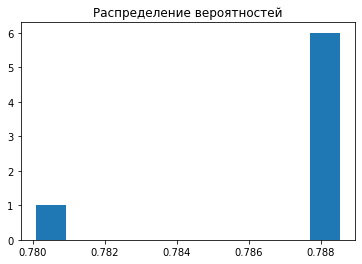

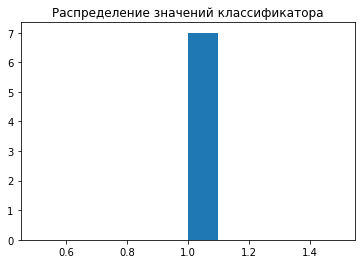

  features  importances
0  MA_slow     0.468204
1     open     0.188717
2  MA_fast     0.112063
3      low     0.111874
4    close     0.042553
5      vol     0.034966
6     high     0.032667
7     MACD     0.008955


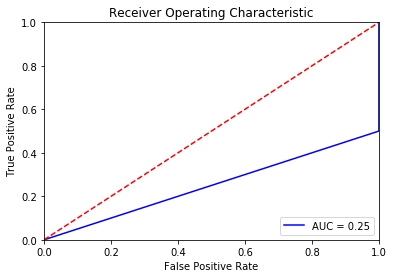



Confusion matrix:
   Pos  Neg
0    0    5
1    0    2

Score = -14.169



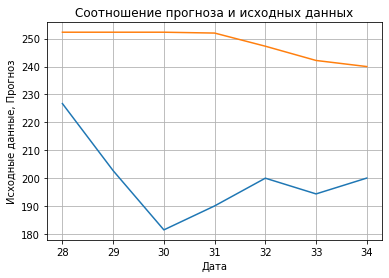

'Model successfully fitted!'

In [9]:
fitpredictionmodel('GAZP', '3m', detailedresults=True)

## Общие процедуры для загрузки данных, ресемплинга и подготовки исходного датафрейма

In [2]:
def fitpredictionmodel(ticker, horizon, detailedresults=False):
    #DataPath = config['PANDORA']['DataPath']
    DataPath = '../data/'
    #ModelsPath = config['PANDORA']['ModelsPath']
    ModelsPath = '../models/'
    
    df = pd.read_csv(DataPath + ticker + '_data.csv')
    df['date_time'] = pd.to_datetime(df.date_time)
    df = df.set_index('date_time')
    
    df = resampledata(df, horizon)
    if len(df) < 60:
        return 'Not enough data for predict'
    df = addfeatures(df)
    
    x_train, x_test, y_train, y_test, y_train_values, y_test_values = preparedata(df, ticker, horizon)
    fitclassifier(ticker, horizon, x_train, x_test, y_train, y_test, ModelsPath, detailedresults=detailedresults)      
    fitregressor(ticker, horizon, x_train, x_test, y_train_values, y_test_values, ModelsPath, detailedresults=detailedresults)
    
    return 'Model successfully fitted!'

In [3]:
def resampledata(df, horizon):
    if horizon in ['1w', '2w', '1m']: # resample to w1
        conversion = {
                        'open': 'first',
                        'high': 'max',
                        'low': 'min',
                        'close': 'last',
                        'vol': 'sum'
                    }
        interval = 'W'
    elif horizon in ['3m', '6m', '1y']: # resample to m1
        conversion = {
                        'open': 'first',
                        'high': 'max',
                        'low': 'min',
                        'close': 'last',
                        'vol': 'sum'
                    }
        interval = 'M'
    else:
        raise ValueError('Wrong horizon pointed!')
        
    downsampled_df = df.resample(interval).apply(conversion)
    downsampled_df.fillna(method='bfill', inplace=True)
    
    return downsampled_df

## Создание новых фич

In [4]:
def addfeatures(df):
    df['MA_fast'] = ta.EMA(df.close, 8)
    df['MA_slow'] = ta.EMA(df.close, 13)
    df['MACD'], _, _ = ta.MACD(df.close, fastperiod=5, slowperiod=35, signalperiod=3)
    
    df.dropna(inplace=True)    
    return df

## Подготовка целевых значений для модели, а также тренировочного и тестовых сетов

In [5]:
def preparedata(df, ticker, horizon):
    if horizon == '1w':
        s = -1
    elif horizon == '2w':
        s = -2
    elif horizon == '1m':
        s = -1
    elif horizon == '3m':
        s = -3
    elif horizon == '6m':
        s = -6
    elif horizon == '1y':
        s = -12
    else:
        raise ValueError('Wrong horizon pointed!')
        
    df['targetPrice'] = df.close.shift(s)
    df['deltaPrice'] = df.close.shift(s) - df.close
    df['deltaPrice'] = np.where(df['deltaPrice'] > 0, 1, 0)  ## 1 = цена возрастёт, 0 = цена упадёт
    
    df['ts'] = df.index.values
    df.reset_index(drop=True, inplace=True)
    df.dropna(inplace=True)
    
    splitCoef = 0.8 # 80 - тренировочный сет, 20 - тестовый сет
    
    ## считаем, сколько цен выше, и сколько ниже текущей (насколько сбалансирован дейтасет)
    countPos = len(df[df.deltaPrice == 1])
    countNeg = len(df[df.deltaPrice == 0])
    print(ticker + ' dataset for fitting model in horizon ' + horizon)
    print(f'Pos: {countPos}   Neg: {countNeg}\n')
    
    df_train, df_test = np.split(df, [int(splitCoef*len(df))])
    print(f'train start: {df_train.ts.iloc[0]}')
    print(f'train end:   {df_train.ts.iloc[-1]}')
    print(f'test start:  {df_test.ts.iloc[0]}')
    print(f'test end:    {df_test.ts.iloc[-1]}')
    df_train.drop(['ts'], axis=1, inplace=True)
    df_test.drop(['ts'], axis=1, inplace=True)
    
    # подготавливаем сеты
    y_train = df_train.deltaPrice
    y_test  = df_test.deltaPrice
    y_train_values = df_train.targetPrice
    y_test_values  = df_test.targetPrice
    
    df_train.drop(['deltaPrice', 'targetPrice'], axis=1, inplace=True)
    df_test.drop(['deltaPrice', 'targetPrice'], axis=1, inplace=True)
    x_train = df_train
    x_test  = df_test
    
    return x_train, x_test, y_train, y_test, y_train_values, y_test_values

## Тренировка модели классификации

In [6]:
def fitclassifier(ticker, horizon, x_train, x_test, y_train, y_test, modelspath, detailedresults=True):
    ## задаём веса для различных классов (балансировка данных)
    #classWeights = len(features[features.label == 0]) / len(features[features.label == 1])
    
    ## параметры классификатора
    xgbParameters = {
        'n_estimators': 500,              ## количество деревьев
        'learning_rate': 0.1,             ## скорость обучения
        'max_depth': 7,                   ## максимальная глубина деревьев
        'subsample': 1.0,                 ## Subsample ratio of the training instance.
        'reg_lambda': 1,                  ## коэффициент L2-регуляризации 
        #'scale_pos_weight': classWeights, ## балансировка данных
        'objective': 'binary:logistic',   ## тип задачи
        'random_state': 42,               ## зерно начального состояния
        'silent': False                   ## не выводить процесс обучения на экран
    }
    
    ## создаём и тренируем классификатор
    clf = xgb.XGBClassifier(**xgbParameters).fit(x_train, y_train)
    
    ## результаты 
    res = pd.concat([x_test, y_test], axis=1)
    print(res.columns)
    res['pred'] = clf.predict(x_test)
    res['pred_proba'] = clf.predict_proba(x_test)[:, 1] ## вероятности
    
    # ошибки первого/второго рода и площать под ROC-кривой
    FPR, TPR, thresholds = roc_curve(res.deltaPrice, res.pred_proba)
    roc_auc = auc(FPR, TPR)
        
    ## точность
    acc = len(res[res.pred == res.deltaPrice]) / len(res)
    print(f"\nAUC = {roc_auc:.3f}\tAccuracy = {acc:.3f}\n")
    
    if detailedresults:
        ## выводим вероятности (уверенность классификтора) 
        plt.hist(res.pred_proba)
        plt.title('Распределение вероятностей')
        plt.show()

        ## выводим распределение значений
        plt.hist(res.pred)
        plt.title('Распределение значений классификатора')
        plt.show()

        ## значительность различных фич (feature importance)
        ftmprt = pd.DataFrame()
        ftmprt['features'] = x_train.columns
        ftmprt['importances'] = clf.feature_importances_
        ftmprt = ftmprt.sort_values('importances', ascending=False).reset_index(drop=True)
        print(ftmprt.head(10))

        # ROC-кривая
        plt.title('Receiver Operating Characteristic')
        plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        ## матрица ошибок
        CM = confusion_matrix(res.deltaPrice, res.pred)
        CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
        print('\n\nConfusion matrix:')
        print(CM_DF)
    
    filename = ticker + '-' + horizon + '-classifier.model'
    with open(modelspath + filename, 'wb') as f:
        pickle.dump(clf, f)

## Тренировка модели регрессии

In [7]:
def fitregressor(ticker, horizon, x_train, x_test, y_train_values, y_test_values, modelspath, detailedresults=True):
    ## параметры для регрессора
    rfRegressorParams = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'max_features' : 1.0}
    
    ## обучаем
    rgs = RandomForestRegressor(**rfRegressorParams).fit(x_train, y_train_values)
    
    ## применяем на тестовых данных
    y_pred_values = rgs.predict(x_test)
    
    ## score
    print(f"\nScore = {rgs.score(x_test, y_test_values):.3f}\n")
    
    if detailedresults:
        ## визуализируем результат
        plt.title("Соотношение прогноза и исходных данных") # заголовок
        plt.xlabel("Дата")         # ось абсцисс
        plt.ylabel("Исходные данные, Прогноз")    # ось ординат
        plt.grid()              # включение отображение сетки
        plt.plot(x_test.index, y_test_values, x_test.index, y_pred_values)  # построение графика
        plt.show()
    
    filename = ticker + '-' + horizon + '-regressor.model'
    with open(modelspath + filename, 'wb') as f:
        pickle.dump(rgs, f)

## Функция осуществления предсказания

In [35]:
def predict(ticker, horizon, predictdate):
    #DataPath = config['PANDORA']['DataPath']
    DataPath = '../data/'
    #ModelsPath = config['PANDORA']['ModelsPath']
    ModelsPath = '../models/'
    
    df = pd.read_csv(DataPath + ticker + '_data.csv')
    df['date_time'] = pd.to_datetime(df.date_time)
    df = df.set_index('date_time')
    df = resampledata(df, horizon)
    df = addfeatures(df)
    
    filename = ticker + '-' + horizon + '-classifier.model'
    if os.path.exists(ModelsPath + filename):
        with open(ModelsPath + filename, 'rb') as f:
            print(f)
            clf = pickle.load(f)
    else:
        print('File ' + ModelsPath + filename + ' not found!')
        return 0, 0, 0, 0
    
    predictdata = df[df.index>=predictdate].head(1)
    clf_predict = clf.predict(predictdata)
    clf_proba = clf.predict_proba(predictdata)
    
    filename = ticker + '-' + horizon + '-regressor.model'
    if os.path.exists(ModelsPath + filename):
        with open(ModelsPath + filename, 'rb') as f:
            print(f)
            rgs = pickle.load(f)
    else:
        print('File ' + ModelsPath + filename + ' not found!')
        return 0, 0, 0, 0
    
    rgs_predict = rgs.predict(predictdata)
    
    print('Predict {0} on {1}. Current price is {2}'.format(ticker, predictdate, predictdata.close.values[0]))
    print('Classifier model predict {0} with probability {1}'.format(clf_predict[0], clf_proba[0]))
    print('Regressor model predict {0}'.format(round(rgs_predict[0],4)))
    
    currentprice = predictdata.close.values[0]
    predictprice = round(rgs_predict[0], 4)
    prctChange = round(((rgs_predict[0] - predictdata.close.values[0])/predictdata.close.values[0])*100, 2)
    
    if clf_predict[0] == 1 and prctChange > 0:
        probability = clf_proba[0][1] * 0.8
    elif clf_predict[0] == 0 and prctChange < 0:
        probability = clf_proba[0][0] * 0.8
    elif clf_predict[0] == 1 and prctChange < 0:
        probability = clf_proba[0][1] * 0.7
    else:
        probability = clf_proba[0][0] * 0.7
        
    print('Model predict price {0} ({1}%) after {2} with probability {3}'.format(predictprice, prctChange, 
                                                                                 horizon, probability))   
    
    return currentprice, predictprice, prctChange, probability

In [34]:
currentprice, predictprice, prctChange, probability = predict('GAZP', '3m', '2020-01-20')

<_io.BufferedReader name='../models/GAZP-3m-classifier.model'>
<_io.BufferedReader name='../models/GAZP-3m-regressor.model'>
Predict GAZP on 2020-01-20. Current price is 226.7
Classifier model predict 1 with probability [0.21146584 0.78853416]
Regressor model predict 251.99
Model predict price 251.99 (11.16%) after 3m with probability 0.6308273315429688
